### 3.1 Simple Robbins Monro

Write the first order budget constraint as :$$F(w) = E[(R-\mu)(R-\mu)']w + \lambda \mathbf{1}_n = Sw + \lambda \mathbf{1}_n=0,$$ 
We can write $F(w) = E(f(w, R)),$ where $$f(w,R) = (R-\mu)(R-\mu)'w + \lambda\mathbf{1}_n$$
We can easily verify the 2 assumptions: 

* if $w*$ is the solution, $\forall w\in \mathbb{R}^n$,
\begin{eqnarray}
 \langle w - w*, F(w)\rangle &=& \langle w-w*, Sw + \lambda \mathbf{1}_n\rangle \\
 &=& \langle w-w*, S(w-w*) + Sw*+ \lambda \mathbf{1}_n\rangle \\
 &=&\langle w-w*, S(w-w*)\rangle >0
\end{eqnarray}


* $\forall w\in \mathbb{R}^n, E(f^2(w, R)) = E(w^TA^2w+2w^TA\cdot\lambda\mathbf{1}_n+n\lambda^2\leq C(1+|w|^2),$where$A = (R-\mu)(R-\mu)',$ when $C$ is quite large. 

In [26]:
import numpy as np
import scipy 
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm,

In [2]:
n = 3
mu = np.array([.05, .07, .06])  # R~ N(mu, S)
D = np.diag([.1, .14, .2])      # S = DKD
rho = 0.5
K = np.array([[1, rho, 0],
             [rho, 1, rho],
             [0, rho, 1]])
lambd = 0.3
S = np.matmul(np.matmul(D, K), D)

In [3]:
def f(w, R, lambd = lambd):
    """
    function for Robbins Monro regression
        E[f(w,R)] = F(w) = 0 
    
    inputs :
            w :   w_n-1 in the regression
            R :   A random vector to perform the RM
        lambd :   eigenvalue default by 0.3
    return : f(w,R)
    """
    t1 = R.reshape(n, 1)   # reshape R^n vectors into col-vectors
    t2 = mu.reshape(n, 1)
    return np.matmul((t1 - t2)*((t1 - t2).T), w) + lambd*np.ones((n, 1))

In [4]:
def plot_trace(h):
    l = np.shape(h)[0]
    hh = np.array(h)
    plt.plot(hh[:l,0])
    plt.ylim(-1.,1.)
    plt.show()
def theory_answer(S):
    inv = np.linalg.inv(S)
    w = np.matmul(inv, np.ones((n, 1)))/np.sum(inv)
    return w

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:18<00:00, 52859.22it/s]


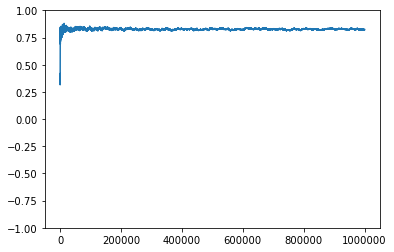

final result is 
 [[ 0.82358368]
 [-0.03598932]
 [ 0.21240563]]
compare with the theory result 
 [[ 0.82688391]
 [-0.0407332 ]
 [ 0.21384929]]


In [5]:
def Robbins_Monro_Regression(N = 10000, alpha = 0.6):
    R = np.random.multivariate_normal(mu, S, N)
    x = np.random.random(n)
    x = x/np.sum(x)
    w = [x.reshape(n,1)]     # initialization with equal value
    w_hist = [x.reshape(n,1)]
    rg = range(N)
    if N > 1e4 :
        rg = tqdm(rg)
    for i in rg:
        w_tmp = w[-1] - 10.*f(w[-1], R[i])/np.power(i+1,alpha)
        w.append(w_tmp)
        w_hist.append(w_tmp/np.sum(w_tmp))
    plot_trace(w_hist)
    print("final result is \n {}".format(w[-1]/np.sum(w[-1])))
    print("compare with the theory result \n {}".format(theory_answer(S)))
    return w[-1]/np.sum(w[-1]),w,w_hist
x,_,_ = Robbins_Monro_Regression(N = 1000000,alpha = 0.6)

## 3.2

In [6]:
def S_rho(rho):
    D = np.diag([.1, .14, .2])
    # rho = 0.5
    K = np.array([[1, rho, 0],
                 [rho, 1, rho],
                 [0, rho, 1]])
    S = np.matmul(np.matmul(D, K), D)
    return S

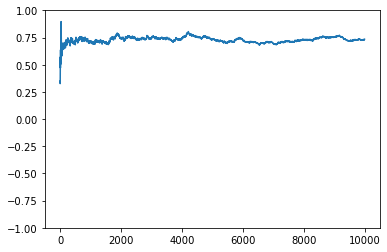

final result is 
 [[0.73428115]
 [0.09775626]
 [0.16796259]]
compare with the theory result 
 [[0.73492551]
 [0.09458501]
 [0.17048948]]


In [7]:
S = S_rho(rho=0.4)
_,_,_ = Robbins_Monro_Regression(alpha=0.6)

In [9]:
def UQSA_adapted(rho_min, rho_max, u0 = '', K = 1000, n = 3, a = 0.875, b = 0.3):   # mk
    m = [int(np.floor(np.power(k, b))) + 1 for k in range(K+1)]   #   mk[0] = 1
    if u0=='' : 
        u0 = np.random.randn(m[0] + 1, n)   

    B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([rho_min, rho_max])) for i in range(np.max(m)+1)]   
        
    def W(m_k, rho, u0, Legendre_basis = B):
        return np.sum([u0[j]*Legendre_basis[j](rho) for j in range(m_k+1)], axis = 0)
#     trace = []
    for k in tqdm(range(1, K+1)):

        r = np.random.uniform(low = rho_min, high = rho_max)
        S = S_rho(r)
        R = np.random.multivariate_normal(mu, S)
        
        u = np.zeros((m[k] + 1, n))
        for i in range(m[k] + 1):
            w = W(m[k-1], r, u0)
#             trace.append(w[0])
            expect = (B[i](r) * f(w.reshape(n,1), R)).reshape(n)
            
            gamma = 1./np.power(k, a) #stepsize
            
            if i > m[k-1]:
                u[i] = - gamma * expect
            else:
                u[i] = u0[i] - gamma * expect
            
            u0 = u
    return u

In [10]:
def result_UQSA_adapted(r,K=1000):
    u = UQSA_adapted(0.3,0.5,K=K)
#     print(u)
    rg = range(int(np.floor(np.power(K, 0.3))) + 1 )
    B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([0.6, 0.8])) for i in rg]
    result = np.zeros(3)
    
    for j in rg:
        result = result + B[j](r)*u[j]
#     plt.plot(trace)
    return result/np.sum(result)

In [11]:
result_UQSA_adapted(0.4, 1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 976.30it/s]


array([-0.13824188,  0.78895732,  0.34928456])

**Timestamp : 2020 Nov 12**

In [166]:
class UQSA_generator:
    def __init__(self,K,n = 3, r_min = 0.3, r_max = 0.5, gamma = None,m = None,M = None):
        self.K = K
        self.gamma = [1./np.power(k,0.3) for k in range(K+1)]
        self.m = [int(np.floor(np.power(k, 0.24))) + 1 for k in range(K+1)]
        if M is None:
            self.M = [5]*K
        else:
            self.M = M
        self.u0 = None
        self.r_min = r_min
        self.r_max = r_max
        self.LB = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([r_min, r_max])) for i in range(np.max(self.m)+1)]
        
    def f(self, w, R, lambd = 0.3):
        """
        function for Robbins Monro regression
            E[f(w,R)] = F(w) = 0 

        inputs :
                w :   w_n-1 in the regression
                R :   A random vector to perform the RM
            lambd :   eigenvalue default by 0.3
        return : f(w,R)
        """
        t1 = R.reshape(n, 1)   # reshape R^n vectors into col-vectors
        t2 = mu.reshape(n, 1)
        return np.matmul((t1 - t2)*((t1 - t2).T), w) + lambd*np.ones((n, 1))

    def W(self,m_k, rho, u0):
#         print(u0[2])
#         print(self.LB[2](rho))
        return np.sum([u0[j]*self.LB[j](rho) for j in range(m_k+1)], axis = 0)
    
    def S_rho(self, rho):
        D = np.diag([.1, .14, .2])
        # rho = 0.5
        K = np.array([[1, rho, 0],
                     [rho, 1, rho],
                     [0, rho, 1]])
        S = np.matmul(np.matmul(D, K), D)
        return S
    
    def omega_theory(self,r):
        S = self.S_rho(r)
        inv = np.linalg.inv(S)
        w = np.matmul(inv, np.ones((n, 1)))/np.sum(inv)
        return w
    
    def u0_initialization(self):
        res = []
        for i in range(7):
            res_i = []
            for j in range(3):
                func = lambda r: self.omega_theory(r)[j] * self.LB[i](r)
                res_i.append(quad(func,self.r_min,self.r_max)[0])
            res.append(res_i)
        self.u0 = res
        return res

    
    def iteration(self):
        u0 = np.array(self.u0)
        for k in tqdm(range(1, self.K+1)):
            r = np.random.uniform(low = self.r_min, high = self.r_max)
            S = self.S_rho(r)
            R = np.random.multivariate_normal(mu, S)
            u = np.zeros((self.m[k] + 1, n))
            
            for i in range(self.m[k] + 1):
                w = self.W(self.m[k-1], r, u0)
                expect = (self.LB[i](r) * self.f(w.reshape(n,1), R)).reshape(n)
    #             gamma = 1./np.power(k, a) #stepsize
                if i > self.m[k-1]:
                    u[i] = - self.gamma[k] * expect
                else:
                    u[i] = u0[i] - self.gamma[k] * expect
                u0 = u
        return u
    def run_out(self):
        self.u0_initialization()
        res = self.iteration()
        print(res)
        return res

In [167]:

uqsa = UQSA_generator(K=1000)
u = uqsa.run_out()

C:\Users\konglulu\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1663.90it/s]

[[-2.77134275e+00 -2.67538768e+00 -2.43515698e+00]
 [-4.66698499e-04 -4.65620968e-04 -4.30221897e-04]
 [-2.29407209e-04 -2.28877469e-04 -2.11474435e-04]
 [ 1.90210682e-05  1.89771438e-05  1.75341386e-05]
 [ 1.97486729e-04  1.97030683e-04  1.82048640e-04]
 [ 2.56367356e-04  2.55775324e-04  2.36325889e-04]
 [ 1.94513452e-04  1.94064241e-04  1.79306742e-04]]


In [170]:
x = uqsa.W(6,0.7,u)
x/np.sum(x)

array([0.39589925, 0.32823857, 0.27586219])

In [156]:
test = uqsa.iteration()

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1659.79it/s]


In [8]:
def UQSA_adapted(rho_min, rho_max, u0 = '', K = 1000, n = 3, a = 0.875, b = 0.24):   # mk
    # part to decide m_k
    m = [int(np.floor(np.power(k, b))) + 1 for k in range(K+1)]   #   mk[0] = 1  
    
    # initialisation of u0
    if u0=='' : 
        u0 = np.random.randn(m[0] + 1, n)   
    
    #legendre basis
    B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([rho_min, rho_max])) for i in range(np.max(m)+1)]   
        
    def W(m_k, rho, u0, Legendre_basis = B):
        return np.sum([u0[j]*Legendre_basis[j](rho) for j in range(m_k+1)], axis = 0)
#     trace = []
    for k in tqdm(range(1, K+1)):

        r = np.random.uniform(low = rho_min, high = rho_max)
        S = S_rho(r)
        R = np.random.multivariate_normal(mu, S)
        
        u = np.zeros((m[k] + 1, n))
        for i in range(m[k] + 1):
            w = W(m[k-1], r, u0)
            expect = (B[i](r) * f(w.reshape(n,1), R)).reshape(n)
            
            gamma = 1./np.power(k, a) #stepsize
            
            if i > m[k-1]:
                u[i] = - gamma * expect
            else:
                u[i] = u0[i] - gamma * expect
            
            u0 = u
    return u

In [14]:
np.power(1000,0.24)

5.248074602497725

In [15]:
K = 1000
n = 3
a = 0.875
b = 0.24


SyntaxError: can't assign to literal (<ipython-input-15-35778195790a>, line 1)

In [17]:
B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([0.3,0.5])) for i in range(6)]

In [18]:
B

[Legendre([1.], domain=[0.3, 0.5], window=[-1.,  1.]),
 Legendre([0., 1.], domain=[0.3, 0.5], window=[-1.,  1.]),
 Legendre([0., 0., 1.], domain=[0.3, 0.5], window=[-1.,  1.]),
 Legendre([0., 0., 0., 1.], domain=[0.3, 0.5], window=[-1.,  1.]),
 Legendre([0., 0., 0., 0., 1.], domain=[0.3, 0.5], window=[-1.,  1.]),
 Legendre([0., 0., 0., 0., 0., 1.], domain=[0.3, 0.5], window=[-1.,  1.])]

In [24]:
def test(r):
    count = 0.0
    for b in B:
        count += b(r)
        print(b(r))
    print("r = ",r,'\n count = ',count)

In [25]:
test(0.4)

1.0
0.0
-0.5
0.0
0.375
0.0
r =  0.4 
 count =  0.875


In [27]:
[5]*3

[5, 5, 5]

In [43]:
def a(x):
    return np.array([x-1,x,x+1])

In [44]:
a(3)

array([2, 3, 4])

In [45]:
tes = lambda x:a(x)[0]
tes(5)

4

In [74]:
B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([0.3,0.5])) for i in range(7)]

In [75]:
for i in B:
    print(i(0.3))

1.0
-1.0
1.0
-1.0
0.9999999999999998
-0.9999999999999993
1.0000000000000004


In [101]:
type(B[0])

numpy.polynomial.legendre.Legendre

In [102]:
x = lambda r: B[5](r)

In [105]:
x(0.5)

0.9999999999999993

In [171]:
from tqdm import tqdm, trange
from random import random, randint
from time import sleep

In [173]:
with trange(10) as t:
    for i in t:
        # Description will be displayed on the left
        t.set_description('GEN %i' % i)
        # Postfix will be displayed on the right,
        # formatted automatically based on argument's datatype
        t.set_postfix(loss=random(), gen=randint(1,999), str='h',
                      lst=[1, 2])
        sleep(0.1)

GEN 9: 100%|███████████████████████████████████| 10/10 [00:01<00:00,  9.00it/s, gen=432, loss=0.137, lst=[1, 2], str=h]


In [174]:
with tqdm(total=10, bar_format="{postfix[0]} {postfix[1][value]:>8.2g}",
          postfix=["Batch", dict(value=0)]) as t:
    for i in range(10):
        sleep(0.1)
        t.postfix[1]["value"] = i / 2
        t.update()

Batch      4.5


In [177]:
from tqdm.auto import trange
from time import sleep

for i in trange(4, desc='1st loop'):
            
    sleep(1.)